# TDA for financial time series: persistent homology and landscapes

In [226]:
import numpy as np
from numpy import linalg
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import pandas as pd
import pickle
import gudhi
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
from statsmodels.tsa.stattools import acf
import csv
import dionysus as d

%matplotlib inline

In [192]:
DJIA = pd.read_csv("DowJones.csv",header=0,delimiter=",")
NASDAQ= pd.read_csv("Nasdaq.csv",header=0,delimiter=",")
Russell= pd.read_csv("Russell2000.csv",header=0,delimiter=",")
SP500= pd.read_csv("SP500.csv",header=0,delimiter=",")

#taking the daily closing values of indices
DJIA=DJIA.Close
NASDAQ=NASDAQ.Close
Russell=Russell.Close
SP500=SP500.Close

#convert them into arrays
DJIA = np.asarray(DJIA)
NASDAQ=np.asarray(NASDAQ)
Russell=np.asarray(Russell)
SP500=np.asarray(SP500)

#reshape arrays
DJIA=DJIA.reshape(len(DJIA),1)
NASDAQ=NASDAQ.reshape(len(NASDAQ),1)
Russell=Russell.reshape(len(Russell),1)
SP500=SP500.reshape(len(SP500),1)

#create a time series by merding the 4 incdices together
ts = np.concatenate((DJIA.transpose(),NASDAQ.transpose(),Russell.transpose(),SP500.transpose()))
ts = ts.transpose()

#reverse the time series to analyze the data chronologically 
ts = ts[::-1]

In [193]:
# Calculate the ratio of log returns for time t and t-1
ratio = np.log(ts / np.roll(ts, -1, axis=0))[:-1]

In [194]:
# Put the returns in a dataframe and add dates 
tsdata = pd.DataFrame(ratio)
DJIAdate = pd.read_csv("DowJones.csv",header=0,delimiter=",")
tsdata['date'] = DJIAdate.Date[::-1][:-1].values
tsdata.head()

,0,1,2,3,date
0,0.002981,-0.005115,-0.006518,0.004474,1987-12-23
1,0.028764,0.023073,0.021531,0.025966,1987-12-24
2,0.008310,0.000307,0.005900,0.003999,1987-12-28
3,-0.011973,-0.012821,-0.010093,-0.013281,1987-12-29
4,0.005796,-0.002423,-0.007669,0.003152,1987-12-30


In [195]:
# A function that returns the index for a given date
def ind(date):
    return tsdata[tsdata.date == date].index.values[0]

# Compute the rips diagram and Construct its corresponding persistance landscape

In [196]:
# Construct a persistent landscape function 
def persistent_landscape(dgm, k, xmin, xmax, nb_nodes, nb_ld):
    
    # birth points and the death points of a totplogical feature 
    points = list(map(lambda x: x[1], filter(lambda x: x[0] == k, dgm)))
    
    landscape = np.zeros((nb_ld,nb_nodes))
    node_size = (xmax - xmin) / (nb_nodes - 1)
    for node in range(nb_nodes):
        x = xmin + node * node_size
        
        # map the persistence diagram to the midpoint and the halflife of the birth and death points to construct a piecewise function for this node
        lmbda_k = []
        for b, d in filter(lambda y: y[0] <= x <= y[1], points):
            if x >= (d+b)/2.0:
                lmbda_k.append(d-x)
            else:
                lmbda_k.append(x-b)
                  
        # Sort the points and add it to the landscape
        lmbda_k = np.array(list(reversed(sorted(lmbda_k))))
        for j in range(nb_ld):
            if j < len(lmbda_k):
                landscape[j,node]=lmbda_k[j]
    
    return landscape

In [197]:
# Generates persistent diagram and landscape figures for the given window and start index
def generate_persistence_dig(w, index, title, save=False):
    
    X_n = tsdata.iloc[index:index+w].drop('date', axis=1).values
    
    # Compute the Rips Complex
    rips = gudhi.RipsComplex(points=X_n, max_edge_length=12)
    simplex_tree = rips.create_simplex_tree(max_dimension=2) # Number of homological dimensions, 1 = loops, 2 = voids
    dgm = simplex_tree.persistence()
    
    # Compute the landscape
    nb_nodes = 100
    nb_ld = 1

    vals = np.array(list(map(lambda x: x[1], filter(lambda x: x[0] == 1, dgm))))
    xmin = np.min(vals) - 0.001
    xmax = np.max(vals) + 0.005
    L = compute_persistent_landscape(dgm, 1, xmin, xmax, nb_nodes, nb_ld)
    
    # Plot the persistence diagram
    gs = gridspec.GridSpec(1,2)
    plt.figure(figsize=(10, 3))
    plt.suptitle(title + ' (w='+ str(w) + ')')
    plt.subplot(gs[0])
    gudhi.plot_persistence_diagram(dgm)

    # Plot the persistent landscape
    plt.subplot(gs[1])
    plt.title('Persistent Landscape')
    plt.plot(np.linspace(xmin, xmax, num=nb_nodes), L[:nb_ld,:].transpose())
    plt.subplots_adjust(left=0.2, wspace=0.5, top=0.8)
    
    if save:
        plt.savefig(title  + ' (w='+ str(w) + ')')
    else:
        plt.show()

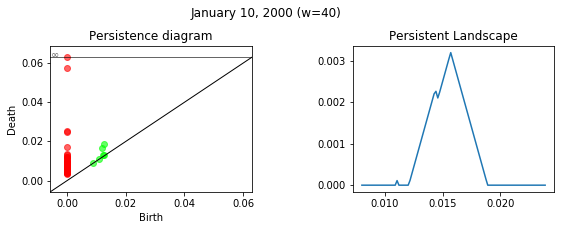

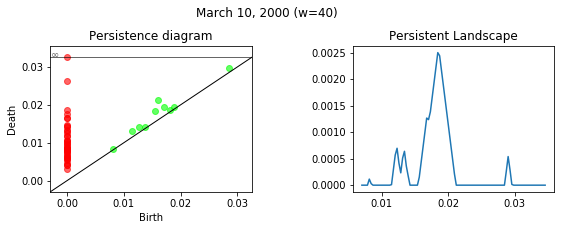

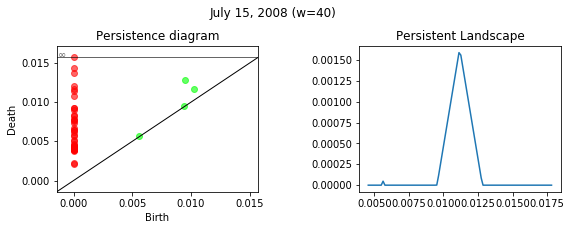

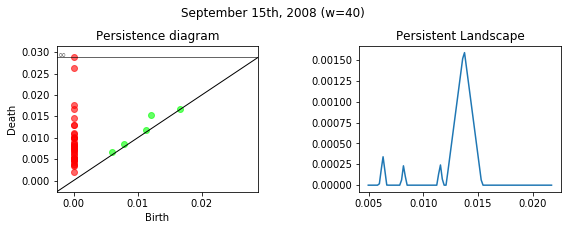

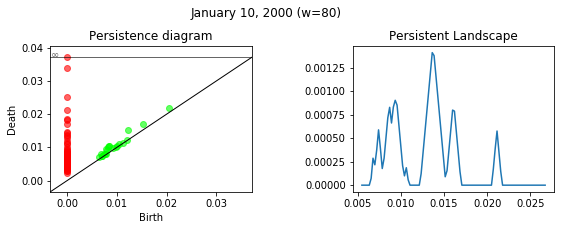

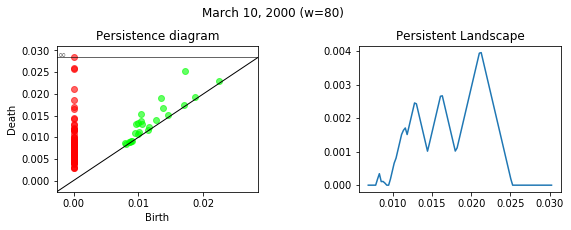

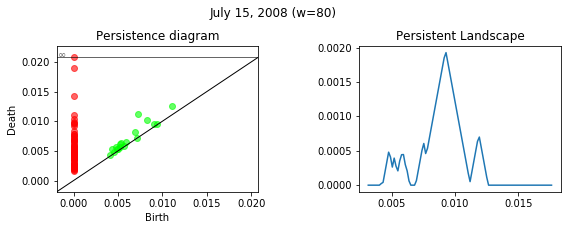

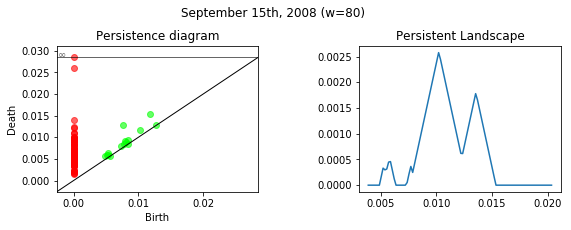

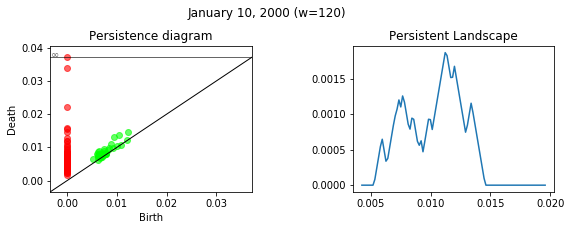

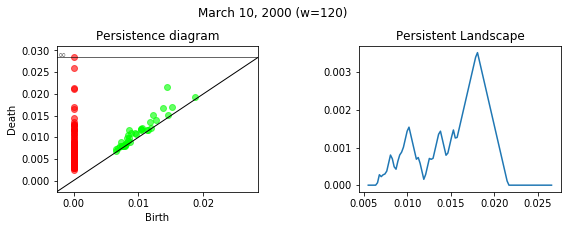

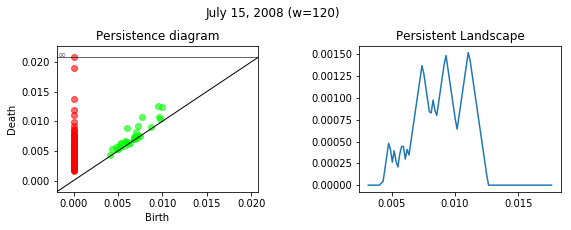

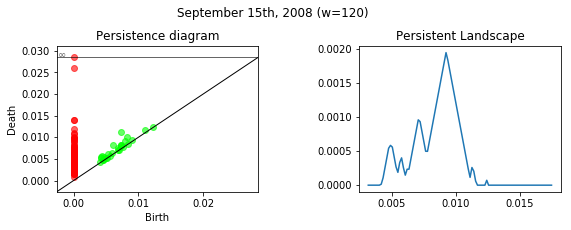

In [198]:
# Generate the figures for the crash dates for different windows
Crash_dates = [('2000-01-10', 'January 10, 2000'),
              ('2000-03-10', 'March 10, 2000'), 
              ('2008-07-15', 'July 15, 2008'), 
              ('2008-09-15', 'September 15th, 2008')]
for w in [40,80,120]:
    for i, t in Crash_dates:
        generate_persistence_dig(w, ind(i) - w, t, save=True)

# Compute the L1 and L2 norms of the landscape and return an array containing the two norms for all the points in the dataset

In [199]:
# Compute L1 and L2 norms from the persistent landscapes
def landscape_norms(start_idx, end_idx, w):
    nb_nodes = 100
    nb_ld = 1

    L1 = []
    L2 = []
    for i in range(start_idx, end_idx):
        cut = tsdata.iloc[i:i+w].drop('date', axis=1).values

        rips = gudhi.RipsComplex(points=cut, max_edge_length=12)
        tree = rips.create_simplex_tree(max_dimension=2)

        dgm = tree.persistence()

        # Get the values for only dimension 1 and compute the min and max
        vals = np.array(list(map(lambda x: x[1], filter(lambda x: x[0] == 1, dgm))))
        try:
            xmin = np.min(vals)
            xmax = np.max(vals)

            # Compute the persistent landscape
            L = persistent_landscape(dgm, 1, xmin, xmax, nb_nodes, nb_ld)

            # Calculate and save the norms
            L1.append(np.linalg.norm(L, ord=1))
            L2.append(np.linalg.norm(L, ord=2))
        except:
            L1.append(0)
            L2.append(0)
        
    return np.array(L1), np.array(L2)

#  Plot the two norms for the two crash dates
Get the norms of the 2 specified crash dates with a sliding window size of 40,80 and 120 and plot the results 

In [203]:
def norm_dig(start, end, w, y):
    L1, L2 = landscape_norms(start, end, w)
    
    # Normalizing the landscapes
    min_max_scaler = MinMaxScaler()
    L1 = min_max_scaler.fit_transform(L1.reshape(-1,1)).reshape(-1)
    L2 = min_max_scaler.fit_transform(L2.reshape(-1,1)).reshape(-1)
    
    # ndf = norm dataframe
    ndf = pd.DataFrame({'L1': L1, 'L2': L2}, index=pd.to_datetime(tsdata.iloc[start:end].date))
    y = ndf.L1.plot(linewidth=2.0, color='r', ax=y)
    y = ndf.L2.plot(linewidth=2.0, color='b', ax=y)

    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    yearsFmt = mdates.DateFormatter('%Y')
    
    y.xaxis.set_major_locator(years)
    y.xaxis.set_major_formatter(yearsFmt)
    y.xaxis.set_minor_locator(months)


    datemin = pd.to_datetime(tsdata.iloc[start].date)
    datemax = pd.to_datetime(tsdata.iloc[end].date)
    y.set_xlim(datemin, datemax)
    y.set_title('Landscape Norm (w=' + str(w) + ')')
    y.legend()
    return y

# Plot for the March 10th 2000 crash

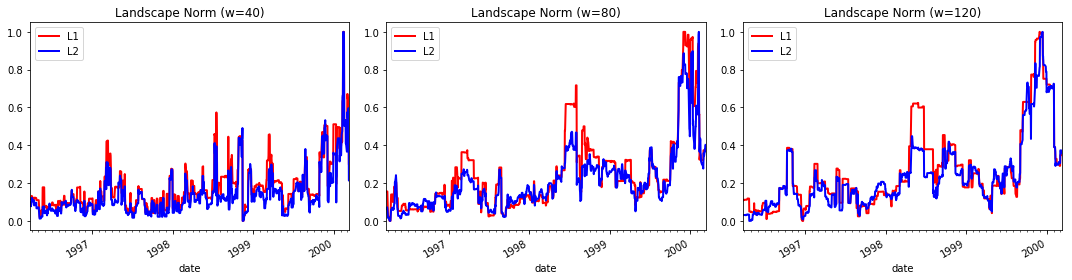

In [204]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

ws = [40,80,120]
for i in range(3):
    w = ws[i]
    period = 1000
    mar = ind('2000-03-10')
    start = mar - period
    end = mar
    norm_dig(start, end, w, y=axs[i])
fig.tight_layout()
fig.savefig('Lpnorm_2000')

# Plot for the September 15th 2008 crash

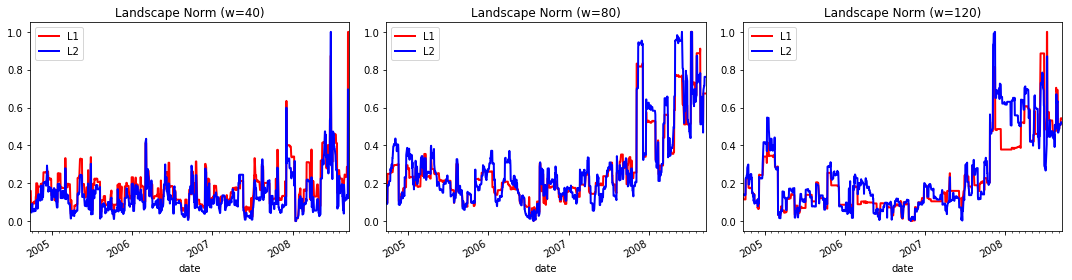

In [147]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

ws = [40,80,120]
for i in range(3):
    w = ws[i]
    sep = ind('2008-09-15')
    start = sep - period
    end = sep
    norm_dig(start, end, w, y=axs[i])
fig.tight_layout()
fig.savefig('Lpnorm_2008')

# Calculate variance of Lp norms for a sliding window of 40 for the dotcom crash of 2000

In [219]:
w = 40
period = 1000
mar = ind('2001-03-01')
start = mar - period
end = mar
L1, L2 = landscape_norms(start, end, w)

# Normalize 
min_max_scaler = MinMaxScaler()
L1 = min_max_scaler.fit_transform(L1.reshape(-1,1)).reshape(-1)
L2 = min_max_scaler.fit_transform(L2.reshape(-1,1)).reshape(-1)

# put it in a dataframe
ndf = pd.DataFrame({'L1': L1, 'L2': L2}, index=pd.to_datetime(tsdata.iloc[start:end].date))

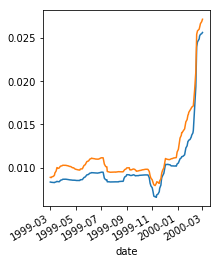

In [231]:
#plot the variance in the L1 and L2 norms 250 days prior to the crash 
w = 250 
j = 0
for i in ndf2000.index:
    ndf.loc[i, 'var_L1'] = np.var(ndf.iloc[j-w:j].L1)
    ndf.loc[i, 'var_L2'] = np.var(ndf.iloc[j-w:j].L2)
    j += 1
ndf.loc['1999-03-01':'2000-03-01'].var_L2.plot(figsize=(3,4))
ndf.loc['1999-03-01':'2000-03-01'].var_L1.plot(figsize=(3,4))

# Calculate variance of Lp norms for a sliding window of 40 for the lehman bros crash of 2008

In [233]:
w = 40
period = 1000
sep = ind('2009-10-01')
start = sep - period
end = sep
L1, L2 = landscape_norms(start, end, w)

# Normalize 
min_max_scaler = MinMaxScaler()
L1 = min_max_scaler.fit_transform(L1.reshape(-1,1)).reshape(-1)
L2 = min_max_scaler.fit_transform(L2.reshape(-1,1)).reshape(-1)

# put it in a dataframe
ndf = pd.DataFrame({'L1': L1, 'L2': L2}, index=pd.to_datetime(tsdata.iloc[start:end].date))

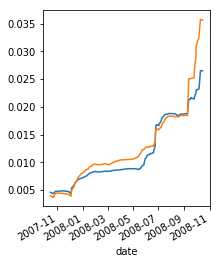

In [234]:
#plot the variance in the L1 and L2 norms 250 days prior to the crash 
w = 250 
j = 0
for i in ndf.index:
    ndf.loc[i, 'var_L1'] = np.var(ndf.iloc[j-w:j].L1)
    ndf.loc[i, 'var_L2'] = np.var(ndf.iloc[j-w:j].L2)
    j += 1
ndf.loc['2007-10-15':'2008-10-15'].var_L2.plot(figsize=(3,4))
ndf.loc['2007-10-15':'2008-10-15'].var_L1.plot(figsize=(3,4))

# Bottleneck Distance

1).Select the window size 2).We loop through the dataset 3).We compute the rips diagram 4).We compute the Bottleneck distance between the current rips diagram and the previous one 5).We save the distance 6).We save the current rips diagram as previous diagram

In [227]:
def bottleneck(start, end, w):

    D = []
    last = None
    for i in range(start, end):
        dat_1 = tsdata.iloc[i:i+w].drop('date', axis=1).values
        dat_2 = tsdata.iloc[i+1:i+w+1].drop('date', axis=1).values


        dgms1 = None
        if last is None:
            f1 = d.fill_rips(dat_1, 2, 1)
            m1 = d.homology_persistence(f1)
            dgms1 = d.init_diagrams(m1, f1)
        else:
            dgms1 = last
    
        f2 = d.fill_rips(dat_2, 2, 1)
        m2 = d.homology_persistence(f2)
        dgms2 = d.init_diagrams(m2, f2)

        distance = d.bottleneck_distance(dgms1[1], dgms2[1], 0.2)
        D.append(distance)
        last = dgms2
    return D

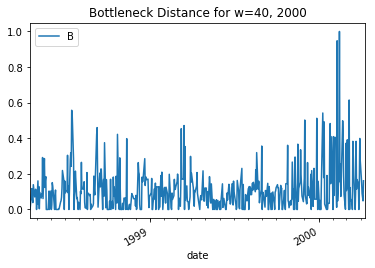

In [228]:
# Window and period for bottleneck 
w = 40
period = 500
mar = ind('2000-04-10')
start = mar - period
end = mar

# Calculate the norm 
L1, L2 = landscape_norms(start, end, w)

min_max_scaler = MinMaxScaler()
L1 = min_max_scaler.fit_transform(L1.reshape(-1,1)).reshape(-1)
L2 = min_max_scaler.fit_transform(L2.reshape(-1,1)).reshape(-1)


# Calculate the bottleneck distance
D = bottleneck(start, end, w)
D_normalised = min_max_scaler.fit_transform(np.array(D).reshape(-1,1)).reshape(-1)

# put it into a dataframe
bdf = pd.DataFrame({'L1': L1, 'L2': L2, 'B':D_normalised}, index=pd.to_datetime(tsdata.iloc[start:end].date))

# Plot the bottleneck distance
y = bdf.B.plot()
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

y.xaxis.set_major_locator(years)
y.xaxis.set_major_formatter(yearsFmt)
y.xaxis.set_minor_locator(months)

datemin = pd.to_datetime(tsdata.iloc[start].date)
datemax = pd.to_datetime(tsdata.iloc[end].date)
y.set_xlim(datemin, datemax)
y.set_title('Bottleneck Distance for w=40, 2000')
y.legend()
plt.savefig('bottleneck2000')

# Bottleneck for 2008

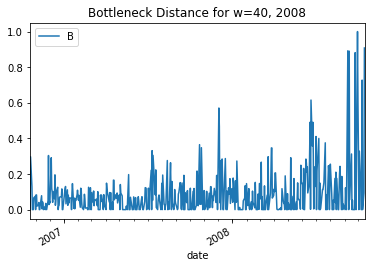

In [230]:
w = 40
period = 500
sep = ind('2008-10-15')
start_2008 = sep - period
end_2008 = sep

# Calculate the norm 
L1_2008, L2_2008 = landscape_norms(start_2008, end_2008, w)

min_max_scaler = MinMaxScaler()
L1_2008 = min_max_scaler.fit_transform(L1_2008.reshape(-1,1)).reshape(-1)
L2_2008 = min_max_scaler.fit_transform(L2_2008.reshape(-1,1)).reshape(-1)

# Calculate the bottleneck distance
D_2008 = bottleneck(start_2008, end_2008, w)
D_normalised_2008 = min_max_scaler.fit_transform(np.array(D_2008).reshape(-1,1)).reshape(-1)

# put it into a dataframe
bdf = pd.DataFrame({'L1': L1_2008, 'L2': L2_2008, 'B':D_normalised_2008}, index=pd.to_datetime(tsdata.iloc[start_2008:end_2008].date))

# Plot the bottleneck distance
y = bdf.B.plot()
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

y.xaxis.set_major_locator(years)
y.xaxis.set_major_formatter(yearsFmt)
y.xaxis.set_minor_locator(months)

datemin = pd.to_datetime(tsdata.iloc[start_2008].date)
datemax = pd.to_datetime(tsdata.iloc[end_2008].date)
y.set_xlim(datemin, datemax)
y.set_title('Bottleneck Distance for w=40, 2008')
y.legend()
plt.savefig('bottleneck2008')

# First lag ACF for the dotcom crash

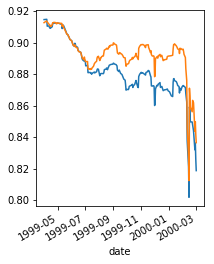

In [189]:
#window and period for ACF
w = 40
period = 500
mar = ind('2001-03-01')
start = mar - period
end = mar
L1, L2 = landscape_norms(start, end, w)

# Normalize 
min_max_scaler = MinMaxScaler()
L1 = min_max_scaler.fit_transform(L1.reshape(-1,1)).reshape(-1)
L2 = min_max_scaler.fit_transform(L2.reshape(-1,1)).reshape(-1)

# put it in a dataframe
ndf = pd.DataFrame({'L1': L1, 'L2': L2}, index=pd.to_datetime(tsdata.iloc[start:end].date))

w = 250
j = 0
for i in ndf.index:
    if j + w >= ndf.shape[0]:
        break
    
    ndf.loc[i, 'acf_L1'] = acf(ndf.iloc[j:j+w].L1)[1]
    ndf.loc[i, 'acf_L2'] = acf(ndf.iloc[j:j+w].L2)[1]
    j += 1
ndf.loc['1999-04-01':'2000-04-01'].acf_L1.plot(figsize=(3,4))
ndf.loc['1999-04-01':'2000-04-01'].acf_L2.plot(figsize=(3,4))